In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../..")


import neuroprob as mdl
from neuroprob import utils

import utils_func

dev = utils.pytorch.get_device()

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [2]:
# loading data
dataset = 'hc3'
session_id = 'ec014.468'

data = np.load('./checkpoint/{}_{}.npz'.format(dataset, session_id))
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
eeg_t = data['eeg_t']
sample_bin = data['sample_bin']

units = spktrain.shape[0]
track_samples = spktrain.shape[1]

In [5]:
# select data
unit_used = np.where(spktrain.sum(-1) > 50)[0]
units_used = len(unit_used)

# bin
bin_size = 500 # 400 ms
tbin, resamples, rc_t, (rx_t, ry_t, rhd_t,) = utils.neural.bin_data(bin_size, sample_bin, spktrain[unit_used, :], 
                                                        track_samples, (x_t, y_t, np.unwrap(hd_t)), average_behav=True, binned=True)

print(resamples)

9755


In [6]:
left_x = x_t.min()
right_x = x_t.max()
bottom_y = y_t.min()
top_y = y_t.max()

arena_width = right_x - left_x
arena_height = top_y - bottom_y

track_samples = len(x_t)

In [13]:
deep_gp = False

if deep_gp: # base GP
    base_d = 1
    lat_dims = 2

    num_induc = 32
    inducing_points = np.array([np.linspace(0, resamples*tbin, num_induc)]).T[None, ...].repeat(lat_dims, axis=0)

    l = 10.0*np.ones(lat_dims)
    v = np.ones(lat_dims)
    kernels_tuples = [('OU', 'euclid', np.array([l]))]
    gp_base = mdl.nonparametrics.Gaussian_process(base_d, lat_dims, kernels_tuples, inducing_points=inducing_points, 
                                                  inv_link='identity', whiten=True, jitter=1e-5)

    
    gp_base_input = mdl.inference.input_group(base_d, [(None, None, None, base_d)])
    times_input = np.arange(resamples-1)*tbin
    gp_base_input.set_XZ([times_input], resamples-1, batch_size=2000)
    
    
# GPLVM or Deep GP
units_ = units_used#1
l = .5*np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('variance', v), ('RBF', 'euclid', np.array([l, l]))]

num_induc = 16
inducing_points = np.array([np.linspace(-1., 1, num_induc), \
                            np.random.randn(num_induc)]).T[None, ...].repeat(units_used, axis=0)
in_dims = inducing_points.shape[-1]


if deep_gp:
    VI_tuples = [(['mapping', (gp_base_input, gp_base)], 'Normal', 'euclid', in_dims)]
else:
    VI_tuples = [(['RW', (np.ones(in_dims)*4.0, np.ones(in_dims)*1.0, True, False)], 
                   'Normal', 'euclid', in_dims)]
    

inputs = mdl.inference.input_group(in_dims, VI_tuples)
ini_X = [
    [np.random.randn(resamples, in_dims)*0.1, np.ones((resamples, in_dims))*0.01]
]
inputs.set_XZ(ini_X, resamples, batch_size=2000, filter_len=1)


gp_lvm = mdl.nonparametrics.Gaussian_process(in_dims, units_used, kernels_tuples, inducing_points=inducing_points, 
                                             whiten=True, jitter=1e-5)


likelihood = mdl.likelihoods.Poisson(tbin, units_used, 'exp')
likelihood.set_Y(rc_t, batch_size=2000, filter_len=1)


# NLL model
glm = mdl.inference.VI_optimized(inputs, gp_lvm, likelihood)
#glm.to(dev)

In [15]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 50, sch)
opt_lr_dict = {'default': 5*1e-3,
               'rate_model.0.lv_std_0': 5*1e-4}#, 'rate_model.0.lv_std_1': 1e-3}
glm.set_optimizers(opt_tuple, opt_lr_dict)


annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=-1e1, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=16, ll_samples=50, ll_mode='MC')

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

The parameter rate_model.0.lv_std_0 is not found in the model.


KeyboardInterrupt: 

In [69]:
# save model
model_name = "GPLVM_linear_track"
torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)

In [25]:
model_name = "GPLVM_linear_track"
checkpoint = torch.load('./checkpoint/' + model_name)
glm.load_state_dict(checkpoint['glm'])

<All keys matched successfully>

In [29]:
# predict latents
X_loc, X_std = gp_lvm.eval_X()
Xsig = X_loc[0].T
Xstd = X_std[0].T

rcov = np.concatenate((rx_t[None], ry_t[None]), axis=0)
scales_arr = [torch.tensor([rx_t.std()*2, ry_t.std()*2], device=dev), 
              torch.tensor([-rx_t.std()*2, ry_t.std()*2], device=dev), 
              torch.tensor([rx_t.std()*2, -ry_t.std()*2], device=dev), 
              torch.tensor([-rx_t.std()*2, -ry_t.std()*2], device=dev)]# take into account reflections

W_, bias_, scale_, losses_ = utils.latent.align_affine_2D(Xsig, rcov, scales_arr, dev=dev, iters=20000, lr=5*1e-3)

aligned_loc = scale_[:, None]*(W_ @ Xsig + bias_[:, None])
aligned_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ Xstd**2))

3425.3814191411334
3425.6199535301266
3425.6084085513166
3425.3746026234912


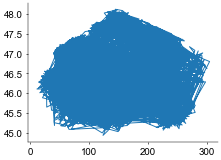

In [30]:
plt.plot(aligned_loc[0], aligned_loc[1])

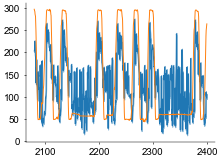

In [31]:
startT = 5200
TT = 800

ax = plt.gca()
tx = np.arange(startT, startT+TT)*tbin

line, = ax.plot(tx, aligned_loc[0][startT:startT+TT])
ax.fill_between(
    tx, aligned_loc[0][startT:startT+TT]-aligned_std[0][startT:startT+TT],
    aligned_loc[0][startT:startT+TT]+aligned_std[0][startT:startT+TT], color=line.get_color(), alpha=0.5
)


plt.plot(tx, rx_t[startT:startT+TT])

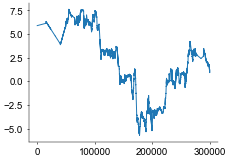

In [39]:
plt.plot(np.unwrap(hd_t[100000:400000]))

In [ ]:
plt.plot(aligned_loc[1][3000:3500])
#plt.plot((x_t[1:]-x_t[:-1])[3000:3500]*10000)
#plt.plot(ry_t[2500:3000])

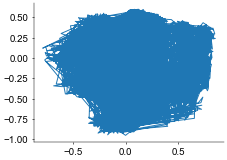

In [23]:
plt.plot(X_loc[0][:, 0], X_loc[0][:, 1])

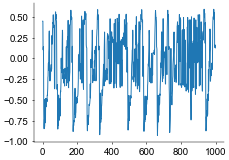

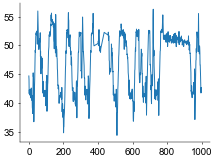

In [38]:
plt.plot(ry_t[5000:6000])

In [63]:
grid_size = (50, 40)
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

show_neurons = np.arange(units_used)

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = np.array([x, y])
    covariates = np.linalg.inv(W_) @ (covariates/scale_[:, None] - bias_[:, None])
    return gp_lvm.eval_rate(covariates, show_neurons).reshape(units_used, *prevshape)

_, field_fit = tools.compute_mesh(grid_size, grid_shape, func)

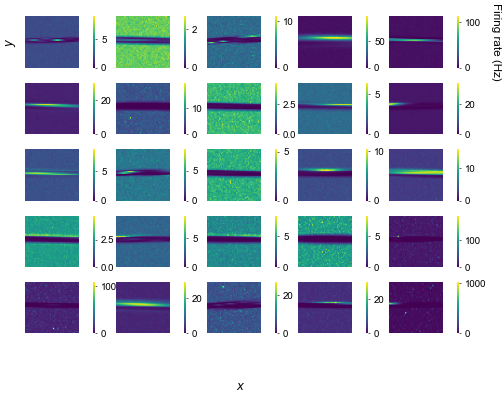

In [67]:
# show fits
grid_size = (50, 40)
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

show_neurons = np.arange(25)

fig = plt.figure(figsize=(8, 6))
nrows = 5
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
    
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = np.array([x, y])
        covariates = np.linalg.inv(W_) @ (covariates/scale_[:, None] - bias_[:, None])
        return gp_lvm.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    if neuron == 4:
        #cbar = True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    #grid_shape = [[-2., 2.], [-2., 2.]]
    _, ax, im = tools.visualize_field(field, grid_shape, ticktitle=ticktitle, figax=(fig, axes[m]), aspect='auto')
    if m == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
    tools.decorate_ax(ax, ylabel=ylabel, spines=[False, False, False, False])
    #xlim=[left_x, right_x], ylim=[bottom_y, top_y],

fig.text(0.51, 0.0, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.3)


plt.show()